In [4]:
import os
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import time
from sklearn.utils import resample
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from numpy import mean, std, dstack
from keras.models import Sequential

# Declare a global variable to store the results
global_results = {}

def load_dataset(path):
    # Load input data and output data
    print('\nLoading dataset...')
    files = os.listdir(path)
    dataX_files = [file for file in files if 'x_' in file]
    datay_files = [file for file in files if 'y_' in file]
    dataX_files.sort()
    datay_files.sort()

    dataX = pd.concat([pd.read_csv(path + '/' + file, delimiter=',') for file in dataX_files])
    
    datay = pd.DataFrame()  # Initialize datay as an empty DataFrame
    unique_label = 1
    for file in datay_files:
        datay_temp = pd.read_csv(path + '/' + file, delimiter=',')
        if (datay_temp.iloc[:, 0] == 1).any():  # Check if there are any 1 values in the first column
            datay_temp.loc[datay_temp.iloc[:, 0] == 1, datay_temp.columns[0]] = unique_label
            if datay.empty:  # If datay is empty, directly assign datay_temp
                datay = datay_temp
            else:
                datay = pd.concat([datay, datay_temp])  # Append only the modified datay_temp
            unique_label += 1

    # Split data into train and test sets
    trainX, testX = model_selection.train_test_split(dataX, test_size=0.10, random_state=42, shuffle=True)
    trainy, testy = model_selection.train_test_split(datay, test_size=0.10, random_state=42, shuffle=True)

    # Get 3D training data (assuming your data requires this step)
    listtrain = [trainX]
    listtest = [testX]
    trainX = dstack(listtrain)
    testX = dstack(listtest)
    print('\nAfter stacking...')
    print('trainX.shape: ', trainX.shape)
    print('testX.shape: ', testX.shape)

    # Calculate number of classes based on unique values in trainy
    num_classes = np.unique(trainy).shape[0]

    # Convert output data to categorical form
    trainy = to_categorical(trainy.values.ravel(), num_classes=num_classes)
    testy = to_categorical(testy.values.ravel(), num_classes=num_classes)
    print('\nAfter categorizing...')
    print('trainy.shape: ', trainy.shape)
    print('testy.shape: ', testy.shape, '\n')

    return trainX, trainy, testX, testy

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
import time
epochs, batch_size = 5, 128  # Reduced number of epochs and increased batch size
print('Number of epochs: ', epochs)
print('Batch size: ', batch_size),
# Declare a global variable to store the results
global_results = {}

from sklearn.ensemble import RandomForestClassifier

def evaluate_model(trainX, trainy, testX, testy):
    n_features, n_added_dimension, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

    # Calculate class weights
    y_integers = np.argmax(trainy, axis=1)
    class_weights = class_weight.compute_sample_weight('balanced', y_integers)
    d_class_weights = dict(enumerate(class_weights))

    # Define your learning rates
    learning_rates = [0.005]

    # Initialize a list to store the predictions from each model
    ensemble_predictions = []

    for lr in learning_rates:
        
        print(f'Training model with learning rate: {lr}')

        for i in range(2):  # Train 2 models
            print(f'Training model {i+1}...')

            # Randomly sample instances from the training data
            indices = np.arange(trainX.shape[0])
            sample_indices = resample(indices, replace=True)
            sample_X, sample_y = trainX[sample_indices], trainy[sample_indices]

            if i == 0:
                # Flatten the data for Random Forest
                trainX_flat = sample_X.reshape(sample_X.shape[0], -1)

                # Convert categorical labels back to 1-D for Random Forest
                trainy_flat = np.argmax(sample_y, axis=1)

                # Define the model with depth 4
                model = RandomForestClassifier(n_estimators=100, max_depth=4)
                model.fit(trainX_flat, trainy_flat)

                # Predict the test set results for RandomForestClassifier
                testX_flat = testX.reshape(testX.shape[0], -1)
                y_pred = model.predict_proba(testX_flat)

            else:
                # Define the LSTM model for the second iteration
                model = Sequential()
                model.add(LSTM(100, input_shape=(n_features, n_added_dimension), return_sequences=True))
                model.add(Dropout(0.2))
                model.add(Conv1D(64, 3, activation='relu'))
                model.add(MaxPooling1D(pool_size=2))
                model.add(Flatten())
                model.add(Dense(50, activation='relu'))
                model.add(Dense(n_outputs, activation='softmax'))

                model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

                # Use early stopping
                early_stopping = EarlyStopping(monitor='val_loss', patience=5) 
                model.fit(sample_X, sample_y, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping], class_weight=d_class_weights)

                # Predict the test set results for LSTM model
                y_pred = model.predict(testX, batch_size=batch_size)

            ensemble_predictions.append(y_pred)

        # Combine the predictions from each model
        ensemble_predictions = np.array(ensemble_predictions)
        ensemble_y_pred = np.argmax(np.mean(ensemble_predictions, axis=0), axis=-1)

                # Convert testy from multilabel-indicator format to multiclass format
        testy_multiclass = np.argmax(testy, axis=1)
        
        # Calculate Accuracy, F1 score, Recall, and Precision
        accuracy = accuracy_score(testy_multiclass, ensemble_y_pred)
        f1 = f1_score(testy_multiclass, ensemble_y_pred, average='weighted')
        recall = recall_score(testy_multiclass, ensemble_y_pred, average='weighted')
        precision = precision_score(testy_multiclass, ensemble_y_pred, average='weighted')
        
        print(f'Accuracy with learning rate {lr}: {accuracy}')
        print(f'F1 Score: {f1}')
        print(f'Recall: {recall}')
        print(f'Precision: {precision}')
        cm = confusion_matrix(testy_multiclass, ensemble_y_pred)
        print('Confusion Matrix:')
        print(cm)

    return accuracy, f1, recall, precision



def run_experiment(repeats, datasetname):
    experiment_start_time = time.time()
    trainX, trainy, testX, testy = load_dataset(datasetname)
    print('Evaluating for ' + datasetname + '...\n')
    data_loading_time = time.time()
    scores = list()
    for r in range(repeats):
        print('Repeat: ', r + 1)
        score = evaluate_model(trainX, trainy, testX, testy)
    print("Duration of loading data: %d seconds" % (data_loading_time - experiment_start_time))
    print("Duration of evaluating model: %d seconds" % (time.time() - data_loading_time))
    print("Duration of whole experiment: %d seconds" % (time.time() - experiment_start_time))
    
run_experiment(1,'C:\\Users\\nalla\\OneDrive\\Provision_PT_838\\dataset\\Data')

Number of epochs:  5
Batch size:  128

Loading dataset...

After stacking...
trainX.shape:  (1557162, 115, 1)
testX.shape:  (173018, 115, 1)

After categorizing...
trainy.shape:  (1557162, 11)
testy.shape:  (173018, 11) 

Evaluating for C:\Users\nalla\OneDrive\Provision_PT_838\dataset\Data...

Repeat:  1
Training model with learning rate: 0.005
Training model 1...
Training model 2...


C:\Users\nalla\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
12166/12166 ━━━━━━━━━━━━━━━━━━━━ 2196s 180ms/step - accuracy: 0.8930 - loss: 0.0886
Epoch 2/5


C:\Users\nalla\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


12166/12166 ━━━━━━━━━━━━━━━━━━━━ 1937s 159ms/step - accuracy: 0.9063 - loss: 0.0611
Epoch 3/5
12166/12166 ━━━━━━━━━━━━━━━━━━━━ 2110s 173ms/step - accuracy: 0.9074 - loss: 0.0597
Epoch 4/5
12166/12166 ━━━━━━━━━━━━━━━━━━━━ 2219s 182ms/step - accuracy: 0.9069 - loss: 0.0604
Epoch 5/5
12166/12166 ━━━━━━━━━━━━━━━━━━━━ 2262s 186ms/step - accuracy: 0.9086 - loss: 0.0589
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 81s 60ms/step
Accuracy with learning rate 0.005: 0.9665352737865425
F1 Score: 0.9643635323870519
Recall: 0.9665352737865425
Precision: 0.9734967301625667
Confusion Matrix:
[[98528     0     0     0     0     1     0     0     0     0     0]
 [    3  5323   299    11     0     0     5     0     1     1     0]
 [    2   316  2579     4     0     0     0     0     0     0     0]
 [    2     0     0  2817     0     0     0     0     0     0     0]
 [    7     0     0     0  8944     1     0     0     0     2     0]
 [   11     0     0     0     0 10397     0     0     0     0     0]
 [    0     0    

In [5]:
import os
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import time
from sklearn.utils import resample
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from numpy import mean, std, dstack
from keras.models import Sequential

# Declare a global variable to store the results
global_results = {}

def load_dataset(path):
    # Load input data and output data
    print('\nLoading dataset...')
    files = os.listdir(path)
    dataX_files = [file for file in files if 'x_' in file]
    datay_files = [file for file in files if 'y_' in file]
    dataX_files.sort()
    datay_files.sort()

    dataX = pd.concat([pd.read_csv(path + '/' + file, delimiter=',') for file in dataX_files])
    
    datay = pd.DataFrame()  # Initialize datay as an empty DataFrame
    unique_label = 1
    for file in datay_files:
        datay_temp = pd.read_csv(path + '/' + file, delimiter=',')
        if (datay_temp.iloc[:, 0] == 1).any():  # Check if there are any 1 values in the first column
            datay_temp.loc[datay_temp.iloc[:, 0] == 1, datay_temp.columns[0]] = unique_label
            if datay.empty:  # If datay is empty, directly assign datay_temp
                datay = datay_temp
            else:
                datay = pd.concat([datay, datay_temp])  # Append only the modified datay_temp
            unique_label += 1

    # Split data into train and test sets
    trainX, testX = model_selection.train_test_split(dataX, test_size=0.10, random_state=42, shuffle=True)
    trainy, testy = model_selection.train_test_split(datay, test_size=0.10, random_state=42, shuffle=True)

    # Get 3D training data (assuming your data requires this step)
    listtrain = [trainX]
    listtest = [testX]
    trainX = dstack(listtrain)
    testX = dstack(listtest)
    print('\nAfter stacking...')
    print('trainX.shape: ', trainX.shape)
    print('testX.shape: ', testX.shape)

    # Calculate number of classes based on unique values in trainy
    num_classes = np.unique(trainy).shape[0]

    # Convert output data to categorical form
    trainy = to_categorical(trainy.values.ravel(), num_classes=num_classes)
    testy = to_categorical(testy.values.ravel(), num_classes=num_classes)
    print('\nAfter categorizing...')
    print('trainy.shape: ', trainy.shape)
    print('testy.shape: ', testy.shape, '\n')

    return trainX, trainy, testX, testy

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
import time
epochs, batch_size = 5, 128  # Reduced number of epochs and increased batch size
print('Number of epochs: ', epochs)
print('Batch size: ', batch_size),
# Declare a global variable to store the results
global_results = {}

from sklearn.ensemble import RandomForestClassifier

def evaluate_model(trainX, trainy, testX, testy):
    n_features, n_added_dimension, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

    # Calculate class weights
    y_integers = np.argmax(trainy, axis=1)
    class_weights = class_weight.compute_sample_weight('balanced', y_integers)
    d_class_weights = dict(enumerate(class_weights))

    # Define your learning rates
    learning_rates = [0.01]

    # Initialize a list to store the predictions from each model
    ensemble_predictions = []

    for lr in learning_rates:
        
        print(f'Training model with learning rate: {lr}')

        for i in range(2):  # Train 2 models
            print(f'Training model {i+1}...')

            # Randomly sample instances from the training data
            indices = np.arange(trainX.shape[0])
            sample_indices = resample(indices, replace=True)
            sample_X, sample_y = trainX[sample_indices], trainy[sample_indices]

            if i == 0:
                # Flatten the data for Random Forest
                trainX_flat = sample_X.reshape(sample_X.shape[0], -1)

                # Convert categorical labels back to 1-D for Random Forest
                trainy_flat = np.argmax(sample_y, axis=1)

                # Define the model with depth 4
                model = RandomForestClassifier(n_estimators=100, max_depth=4)
                model.fit(trainX_flat, trainy_flat)

                # Predict the test set results for RandomForestClassifier
                testX_flat = testX.reshape(testX.shape[0], -1)
                y_pred = model.predict_proba(testX_flat)

            else:
                # Define the LSTM model for the second iteration
                model = Sequential()
                model.add(LSTM(100, input_shape=(n_features, n_added_dimension), return_sequences=True))
                model.add(Dropout(0.2))
                model.add(Conv1D(64, 3, activation='relu'))
                model.add(MaxPooling1D(pool_size=2))
                model.add(Flatten())
                model.add(Dense(50, activation='relu'))
                model.add(Dense(n_outputs, activation='softmax'))

                model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

                # Use early stopping
                early_stopping = EarlyStopping(monitor='val_loss', patience=5) 
                model.fit(sample_X, sample_y, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping], class_weight=d_class_weights)

                # Predict the test set results for LSTM model
                y_pred = model.predict(testX, batch_size=batch_size)

            ensemble_predictions.append(y_pred)

        # Combine the predictions from each model
        ensemble_predictions = np.array(ensemble_predictions)
        ensemble_y_pred = np.argmax(np.mean(ensemble_predictions, axis=0), axis=-1)

                # Convert testy from multilabel-indicator format to multiclass format
        testy_multiclass = np.argmax(testy, axis=1)
        
        # Calculate Accuracy, F1 score, Recall, and Precision
        accuracy = accuracy_score(testy_multiclass, ensemble_y_pred)
        f1 = f1_score(testy_multiclass, ensemble_y_pred, average='weighted')
        recall = recall_score(testy_multiclass, ensemble_y_pred, average='weighted')
        precision = precision_score(testy_multiclass, ensemble_y_pred, average='weighted')
        
        print(f'Accuracy with learning rate {lr}: {accuracy}')
        print(f'F1 Score: {f1}')
        print(f'Recall: {recall}')
        print(f'Precision: {precision}')
        cm = confusion_matrix(testy_multiclass, ensemble_y_pred)
        print('Confusion Matrix:')
        print(cm)

    return accuracy, f1, recall, precision



def run_experiment(repeats, datasetname):
    experiment_start_time = time.time()
    trainX, trainy, testX, testy = load_dataset(datasetname)
    print('Evaluating for ' + datasetname + '...\n')
    data_loading_time = time.time()
    scores = list()
    for r in range(repeats):
        print('Repeat: ', r + 1)
        score = evaluate_model(trainX, trainy, testX, testy)
    print("Duration of loading data: %d seconds" % (data_loading_time - experiment_start_time))
    print("Duration of evaluating model: %d seconds" % (time.time() - data_loading_time))
    print("Duration of whole experiment: %d seconds" % (time.time() - experiment_start_time))
    
run_experiment(1,'C:\\Users\\nalla\\OneDrive\\Provision_PT_838\\dataset\\Data')

Number of epochs:  5
Batch size:  128

Loading dataset...

After stacking...
trainX.shape:  (1557162, 115, 1)
testX.shape:  (173018, 115, 1)

After categorizing...
trainy.shape:  (1557162, 11)
testy.shape:  (173018, 11) 

Evaluating for C:\Users\nalla\OneDrive\Provision_PT_838\dataset\Data...

Repeat:  1
Training model with learning rate: 0.01
Training model 1...
Training model 2...


C:\Users\nalla\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
12166/12166 ━━━━━━━━━━━━━━━━━━━━ 1665s 137ms/step - accuracy: 0.8892 - loss: 0.1155
Epoch 2/5


C:\Users\nalla\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


12166/12166 ━━━━━━━━━━━━━━━━━━━━ 1735s 143ms/step - accuracy: 0.9003 - loss: 0.0679
Epoch 3/5
12166/12166 ━━━━━━━━━━━━━━━━━━━━ 1788s 147ms/step - accuracy: 0.8971 - loss: 0.0679
Epoch 4/5
12166/12166 ━━━━━━━━━━━━━━━━━━━━ 1809s 149ms/step - accuracy: 0.9033 - loss: 0.0645
Epoch 5/5
12166/12166 ━━━━━━━━━━━━━━━━━━━━ 1953s 161ms/step - accuracy: 0.8904 - loss: 0.0710
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 86s 63ms/step
Accuracy with learning rate 0.01: 0.9588250933428892
F1 Score: 0.955077980268233
Recall: 0.9588250933428892
Precision: 0.9681444871602907
Confusion Matrix:
[[98523     0     0     0     0     6     0     0     0     0     0]
 [    1  5574    22     9     0     0     0     0    28     9     0]
 [    2  1670  1185     3     0     0     0     0    39     2     0]
 [    2     0     0  2817     0     0     0     0     0     0     0]
 [   14     0     0     0  8939     1     0     0     0     0     0]
 [   11     0     0     0     0 10397     0     0     0     0     0]
 [    2     0     0

In [6]:
import os
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import time
from sklearn.utils import resample
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from numpy import mean, std, dstack
from keras.models import Sequential

# Declare a global variable to store the results
global_results = {}

def load_dataset(path):
    # Load input data and output data
    print('\nLoading dataset...')
    files = os.listdir(path)
    dataX_files = [file for file in files if 'x_' in file]
    datay_files = [file for file in files if 'y_' in file]
    dataX_files.sort()
    datay_files.sort()

    dataX = pd.concat([pd.read_csv(path + '/' + file, delimiter=',') for file in dataX_files])
    
    datay = pd.DataFrame()  # Initialize datay as an empty DataFrame
    unique_label = 1
    for file in datay_files:
        datay_temp = pd.read_csv(path + '/' + file, delimiter=',')
        if (datay_temp.iloc[:, 0] == 1).any():  # Check if there are any 1 values in the first column
            datay_temp.loc[datay_temp.iloc[:, 0] == 1, datay_temp.columns[0]] = unique_label
            if datay.empty:  # If datay is empty, directly assign datay_temp
                datay = datay_temp
            else:
                datay = pd.concat([datay, datay_temp])  # Append only the modified datay_temp
            unique_label += 1

    # Split data into train and test sets
    trainX, testX = model_selection.train_test_split(dataX, test_size=0.10, random_state=42, shuffle=True)
    trainy, testy = model_selection.train_test_split(datay, test_size=0.10, random_state=42, shuffle=True)

    # Get 3D training data (assuming your data requires this step)
    listtrain = [trainX]
    listtest = [testX]
    trainX = dstack(listtrain)
    testX = dstack(listtest)
    print('\nAfter stacking...')
    print('trainX.shape: ', trainX.shape)
    print('testX.shape: ', testX.shape)

    # Calculate number of classes based on unique values in trainy
    num_classes = np.unique(trainy).shape[0]

    # Convert output data to categorical form
    trainy = to_categorical(trainy.values.ravel(), num_classes=num_classes)
    testy = to_categorical(testy.values.ravel(), num_classes=num_classes)
    print('\nAfter categorizing...')
    print('trainy.shape: ', trainy.shape)
    print('testy.shape: ', testy.shape, '\n')

    return trainX, trainy, testX, testy

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
import time
epochs, batch_size = 5, 128  # Reduced number of epochs and increased batch size
print('Number of epochs: ', epochs)
print('Batch size: ', batch_size),
# Declare a global variable to store the results
global_results = {}

from sklearn.ensemble import RandomForestClassifier

def evaluate_model(trainX, trainy, testX, testy):
    n_features, n_added_dimension, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

    # Calculate class weights
    y_integers = np.argmax(trainy, axis=1)
    class_weights = class_weight.compute_sample_weight('balanced', y_integers)
    d_class_weights = dict(enumerate(class_weights))

    # Define your learning rates
    learning_rates = [0.0005]

    # Initialize a list to store the predictions from each model
    ensemble_predictions = []

    for lr in learning_rates:
        
        print(f'Training model with learning rate: {lr}')

        for i in range(2):  # Train 2 models
            print(f'Training model {i+1}...')

            # Randomly sample instances from the training data
            indices = np.arange(trainX.shape[0])
            sample_indices = resample(indices, replace=True)
            sample_X, sample_y = trainX[sample_indices], trainy[sample_indices]

            if i == 0:
                # Flatten the data for Random Forest
                trainX_flat = sample_X.reshape(sample_X.shape[0], -1)

                # Convert categorical labels back to 1-D for Random Forest
                trainy_flat = np.argmax(sample_y, axis=1)

                # Define the model with depth 4
                model = RandomForestClassifier(n_estimators=100, max_depth=4)
                model.fit(trainX_flat, trainy_flat)

                # Predict the test set results for RandomForestClassifier
                testX_flat = testX.reshape(testX.shape[0], -1)
                y_pred = model.predict_proba(testX_flat)

            else:
                # Define the LSTM model for the second iteration
                model = Sequential()
                model.add(LSTM(100, input_shape=(n_features, n_added_dimension), return_sequences=True))
                model.add(Dropout(0.2))
                model.add(Conv1D(64, 3, activation='relu'))
                model.add(MaxPooling1D(pool_size=2))
                model.add(Flatten())
                model.add(Dense(50, activation='relu'))
                model.add(Dense(n_outputs, activation='softmax'))

                model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

                # Use early stopping
                early_stopping = EarlyStopping(monitor='val_loss', patience=5) 
                model.fit(sample_X, sample_y, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping], class_weight=d_class_weights)

                # Predict the test set results for LSTM model
                y_pred = model.predict(testX, batch_size=batch_size)

            ensemble_predictions.append(y_pred)

        # Combine the predictions from each model
        ensemble_predictions = np.array(ensemble_predictions)
        ensemble_y_pred = np.argmax(np.mean(ensemble_predictions, axis=0), axis=-1)

                # Convert testy from multilabel-indicator format to multiclass format
        testy_multiclass = np.argmax(testy, axis=1)
        
        # Calculate Accuracy, F1 score, Recall, and Precision
        accuracy = accuracy_score(testy_multiclass, ensemble_y_pred)
        f1 = f1_score(testy_multiclass, ensemble_y_pred, average='weighted')
        recall = recall_score(testy_multiclass, ensemble_y_pred, average='weighted')
        precision = precision_score(testy_multiclass, ensemble_y_pred, average='weighted')
        
        print(f'Accuracy with learning rate {lr}: {accuracy}')
        print(f'F1 Score: {f1}')
        print(f'Recall: {recall}')
        print(f'Precision: {precision}')
        cm = confusion_matrix(testy_multiclass, ensemble_y_pred)
        print('Confusion Matrix:')
        print(cm)

    return accuracy, f1, recall, precision



def run_experiment(repeats, datasetname):
    experiment_start_time = time.time()
    trainX, trainy, testX, testy = load_dataset(datasetname)
    print('Evaluating for ' + datasetname + '...\n')
    data_loading_time = time.time()
    scores = list()
    for r in range(repeats):
        print('Repeat: ', r + 1)
        score = evaluate_model(trainX, trainy, testX, testy)
    print("Duration of loading data: %d seconds" % (data_loading_time - experiment_start_time))
    print("Duration of evaluating model: %d seconds" % (time.time() - data_loading_time))
    print("Duration of whole experiment: %d seconds" % (time.time() - experiment_start_time))
    
run_experiment(1,'C:\\Users\\nalla\\OneDrive\\Provision_PT_838\\dataset\\Data')

Number of epochs:  5
Batch size:  128

Loading dataset...

After stacking...
trainX.shape:  (1557162, 115, 1)
testX.shape:  (173018, 115, 1)

After categorizing...
trainy.shape:  (1557162, 11)
testy.shape:  (173018, 11) 

Evaluating for C:\Users\nalla\OneDrive\Provision_PT_838\dataset\Data...

Repeat:  1
Training model with learning rate: 0.0005
Training model 1...
Training model 2...


C:\Users\nalla\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
12166/12166 ━━━━━━━━━━━━━━━━━━━━ 1722s 141ms/step - accuracy: 0.8957 - loss: 0.0962
Epoch 2/5


C:\Users\nalla\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


12166/12166 ━━━━━━━━━━━━━━━━━━━━ 1756s 144ms/step - accuracy: 0.9353 - loss: 0.0378
Epoch 3/5
12166/12166 ━━━━━━━━━━━━━━━━━━━━ 1901s 156ms/step - accuracy: 0.9382 - loss: 0.0347
Epoch 4/5
12166/12166 ━━━━━━━━━━━━━━━━━━━━ 2038s 167ms/step - accuracy: 0.9392 - loss: 0.0332
Epoch 5/5
12166/12166 ━━━━━━━━━━━━━━━━━━━━ 4421s 363ms/step - accuracy: 0.9403 - loss: 0.0311
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 155s 114ms/step
Accuracy with learning rate 0.0005: 0.9938908090487695
F1 Score: 0.9937173464297814
Recall: 0.9938908090487695
Precision: 0.9942445680679182
Confusion Matrix:
[[98528     0     0     0     0     1     0     0     0     0     0]
 [    4  5621     4     2     0     0     0     1    11     0     0]
 [    2     1  2894     1     0     0     0     0     3     0     0]
 [    2     0     0  2817     0     0     0     0     0     0     0]
 [    1     0     0     0  8952     1     0     0     0     0     0]
 [    4     0     0     0     0 10404     0     0     0     0     0]
 [    0     0 

In [7]:
import os
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import time
from sklearn.utils import resample
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from numpy import mean, std, dstack
from keras.models import Sequential

# Declare a global variable to store the results
global_results = {}

def load_dataset(path):
    # Load input data and output data
    print('\nLoading dataset...')
    files = os.listdir(path)
    dataX_files = [file for file in files if 'x_' in file]
    datay_files = [file for file in files if 'y_' in file]
    dataX_files.sort()
    datay_files.sort()

    dataX = pd.concat([pd.read_csv(path + '/' + file, delimiter=',') for file in dataX_files])
    
    datay = pd.DataFrame()  # Initialize datay as an empty DataFrame
    unique_label = 1
    for file in datay_files:
        datay_temp = pd.read_csv(path + '/' + file, delimiter=',')
        if (datay_temp.iloc[:, 0] == 1).any():  # Check if there are any 1 values in the first column
            datay_temp.loc[datay_temp.iloc[:, 0] == 1, datay_temp.columns[0]] = unique_label
            if datay.empty:  # If datay is empty, directly assign datay_temp
                datay = datay_temp
            else:
                datay = pd.concat([datay, datay_temp])  # Append only the modified datay_temp
            unique_label += 1

    # Split data into train and test sets
    trainX, testX = model_selection.train_test_split(dataX, test_size=0.10, random_state=42, shuffle=True)
    trainy, testy = model_selection.train_test_split(datay, test_size=0.10, random_state=42, shuffle=True)

    # Get 3D training data (assuming your data requires this step)
    listtrain = [trainX]
    listtest = [testX]
    trainX = dstack(listtrain)
    testX = dstack(listtest)
    print('\nAfter stacking...')
    print('trainX.shape: ', trainX.shape)
    print('testX.shape: ', testX.shape)

    # Calculate number of classes based on unique values in trainy
    num_classes = np.unique(trainy).shape[0]

    # Convert output data to categorical form
    trainy = to_categorical(trainy.values.ravel(), num_classes=num_classes)
    testy = to_categorical(testy.values.ravel(), num_classes=num_classes)
    print('\nAfter categorizing...')
    print('trainy.shape: ', trainy.shape)
    print('testy.shape: ', testy.shape, '\n')

    return trainX, trainy, testX, testy

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
import time
epochs, batch_size = 5, 128  # Reduced number of epochs and increased batch size
print('Number of epochs: ', epochs)
print('Batch size: ', batch_size),
# Declare a global variable to store the results
global_results = {}

from sklearn.ensemble import RandomForestClassifier

def evaluate_model(trainX, trainy, testX, testy):
    n_features, n_added_dimension, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

    # Calculate class weights
    y_integers = np.argmax(trainy, axis=1)
    class_weights = class_weight.compute_sample_weight('balanced', y_integers)
    d_class_weights = dict(enumerate(class_weights))

    # Define your learning rates
    learning_rates = [0.001]

    # Initialize a list to store the predictions from each model
    ensemble_predictions = []

    for lr in learning_rates:
        
        print(f'Training model with learning rate: {lr}')

        for i in range(2):  # Train 2 models
            print(f'Training model {i+1}...')

            # Randomly sample instances from the training data
            indices = np.arange(trainX.shape[0])
            sample_indices = resample(indices, replace=True)
            sample_X, sample_y = trainX[sample_indices], trainy[sample_indices]

            if i == 0:
                # Flatten the data for Random Forest
                trainX_flat = sample_X.reshape(sample_X.shape[0], -1)

                # Convert categorical labels back to 1-D for Random Forest
                trainy_flat = np.argmax(sample_y, axis=1)

                # Define the model with depth 4
                model = RandomForestClassifier(n_estimators=100, max_depth=4)
                model.fit(trainX_flat, trainy_flat)

                # Predict the test set results for RandomForestClassifier
                testX_flat = testX.reshape(testX.shape[0], -1)
                y_pred = model.predict_proba(testX_flat)

            else:
                # Define the LSTM model for the second iteration
                model = Sequential()
                model.add(LSTM(100, input_shape=(n_features, n_added_dimension), return_sequences=True))
                model.add(Dropout(0.2))
                model.add(Conv1D(64, 3, activation='relu'))
                model.add(MaxPooling1D(pool_size=2))
                model.add(Flatten())
                model.add(Dense(50, activation='relu'))
                model.add(Dense(n_outputs, activation='softmax'))

                model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

                # Use early stopping
                early_stopping = EarlyStopping(monitor='val_loss', patience=5) 
                model.fit(sample_X, sample_y, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping], class_weight=d_class_weights)

                # Predict the test set results for LSTM model
                y_pred = model.predict(testX, batch_size=batch_size)

            ensemble_predictions.append(y_pred)

        # Combine the predictions from each model
        ensemble_predictions = np.array(ensemble_predictions)
        ensemble_y_pred = np.argmax(np.mean(ensemble_predictions, axis=0), axis=-1)

                # Convert testy from multilabel-indicator format to multiclass format
        testy_multiclass = np.argmax(testy, axis=1)
        
        # Calculate Accuracy, F1 score, Recall, and Precision
        accuracy = accuracy_score(testy_multiclass, ensemble_y_pred)
        f1 = f1_score(testy_multiclass, ensemble_y_pred, average='weighted')
        recall = recall_score(testy_multiclass, ensemble_y_pred, average='weighted')
        precision = precision_score(testy_multiclass, ensemble_y_pred, average='weighted')
        
        print(f'Accuracy with learning rate {lr}: {accuracy}')
        print(f'F1 Score: {f1}')
        print(f'Recall: {recall}')
        print(f'Precision: {precision}')
        cm = confusion_matrix(testy_multiclass, ensemble_y_pred)
        print('Confusion Matrix:')
        print(cm)

    return accuracy, f1, recall, precision



def run_experiment(repeats, datasetname):
    experiment_start_time = time.time()
    trainX, trainy, testX, testy = load_dataset(datasetname)
    print('Evaluating for ' + datasetname + '...\n')
    data_loading_time = time.time()
    scores = list()
    for r in range(repeats):
        print('Repeat: ', r + 1)
        score = evaluate_model(trainX, trainy, testX, testy)
    print("Duration of loading data: %d seconds" % (data_loading_time - experiment_start_time))
    print("Duration of evaluating model: %d seconds" % (time.time() - data_loading_time))
    print("Duration of whole experiment: %d seconds" % (time.time() - experiment_start_time))
    
run_experiment(1,'C:\\Users\\nalla\\OneDrive\\Provision_PT_838\\dataset\\Data')

Number of epochs:  5
Batch size:  128

Loading dataset...

After stacking...
trainX.shape:  (1557162, 115, 1)
testX.shape:  (173018, 115, 1)

After categorizing...
trainy.shape:  (1557162, 11)
testy.shape:  (173018, 11) 

Evaluating for C:\Users\nalla\OneDrive\Provision_PT_838\dataset\Data...

Repeat:  1
Training model with learning rate: 0.001
Training model 1...
Training model 2...


C:\Users\nalla\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
12166/12166 ━━━━━━━━━━━━━━━━━━━━ 4481s 368ms/step - accuracy: 0.9000 - loss: 0.0870
Epoch 2/5


C:\Users\nalla\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


12166/12166 ━━━━━━━━━━━━━━━━━━━━ 3765s 309ms/step - accuracy: 0.9354 - loss: 0.0382
Epoch 3/5
12166/12166 ━━━━━━━━━━━━━━━━━━━━ 2544s 209ms/step - accuracy: 0.9377 - loss: 0.0352
Epoch 4/5
12166/12166 ━━━━━━━━━━━━━━━━━━━━ 2657s 218ms/step - accuracy: 0.9382 - loss: 0.0343
Epoch 5/5
12166/12166 ━━━━━━━━━━━━━━━━━━━━ 2767s 227ms/step - accuracy: 0.9402 - loss: 0.0320
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 134s 99ms/step
Accuracy with learning rate 0.001: 0.9927406397022275
F1 Score: 0.9924756790212876
Recall: 0.9927406397022275
Precision: 0.9932590680642815
Confusion Matrix:
[[98528     0     0     0     0     1     0     0     0     0     0]
 [    0  5640     1     2     0     0     0     0     0     0     0]
 [    0     3  2896     2     0     0     0     0     0     0     0]
 [    2     1     0  2816     0     0     0     0     0     0     0]
 [    0     0     0     0  8953     1     0     0     0     0     0]
 [    5     0     0     0     1 10402     0     0     0     0     0]
 [    0     0   

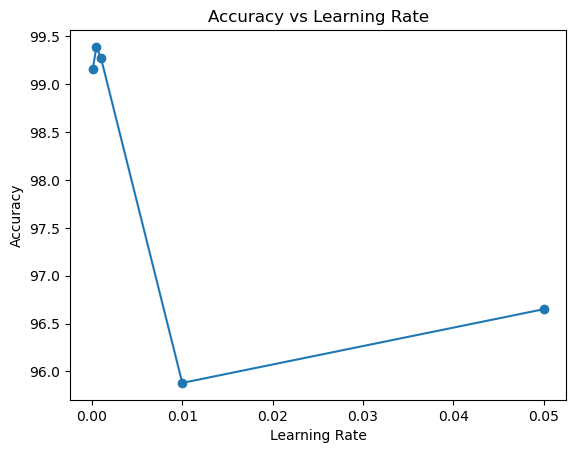

In [2]:
import matplotlib.pyplot as plt

# Data
x = [0.0001, 0.0005, 0.001, 0.01, 0.05]
y = [99.163, 99.389, 99.274, 95.88, 96.65]

# Create the plot
plt.plot(x, y, marker='o')

# Add title and labels
plt.title('Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')

# Show the plot
plt.show()
